# Import and I/O

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# set option so that e.g. df.head() will show all columns and none are omitted 
pd.set_option('display.max_columns', None)

import os
print("Current working directory: ", os.getcwd())

# Specify the year
year = "2010-2015"  # Change this to the desired year

# Define file paths based on the year
csv_file_path = f"..\\Data\\EU\\EU {year}.csv"
parquet_file_path = f"..\\Data\\EU\\EU {year}_dtypes.parquet"
parquet_nanplaceholder_path = f"..\\Data\\EU\\EU {year}_dtypes_nanplaceholder.parquet"
parquet_dupecounts_reduced_path = f"..\\Data\\EU\\EU {year}_dtypes_nanplaceholder_dupecounts_reduced.parquet"
parquet_EU_shared = f"..\\Data\\EU\\EU all_dtypes_Tan_NaN_float32.parquet"

Current working directory:  c:\Users\onepl\Desktop\Finanzen Behörden etc - Copy\Bewerbung\Fortbildungen\DS Bootcamp\Projekt CO2\Notebooks


## read and write

In [6]:
df = pd.read_parquet(parquet_EU_shared)

In [200]:
df.to_parquet("..\\Data\\EU\\EU all_dtypes_Tan_NaN_float32_cleanup_beforeFt.parquet")

In [216]:
df.to_parquet("..\\Data\\EU\\EU all_dtypes_Tan_NaN_float32_cleanup_after Country_tvv.parquet")

In [5]:
df = pd.read_parquet("..\\Data\\EU\\EU all_dtypes_Tan_NaN_float32_cleanup_after Country_tvv.parquet")

## split electric and combustion

In [ ]:
# split electric and pure combustion

df_electric = df[df["Electric range (km)"] > 0]
df_combustion = df[~(df["Electric range (km)"] > 0)]

In [ ]:
# confrim split

len(df_combustion) + len(df_electric) == len(df)

True

# Plot all years

## f: histplot per year

### early version

In [ ]:
# define fuction to plot histograms per year (early version)

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def min_max_normalization(column):
    """
    Custom min-max normalization that sets the minimum to 0 and excludes outliers (values > 1.5*IQR).
    NaN values are left as-is, and the rest of the column is normalized between 0 and 1.
    
    Parameters:
    - column: A pandas Series (column) to normalize.
    
    Returns:
    - A pandas Series with normalized values (0 to 1), NaN values remain unchanged, outliers set to NaN.
    """
    # Remove NaNs for processing
    non_nan_values = column.dropna()
    
    # Set minimum to 0
    col_min = 0
    
    # Calculate IQR (Interquartile Range)
    q1 = np.percentile(non_nan_values, 25)
    q3 = np.percentile(non_nan_values, 75)
    iqr = q3 - q1
    
    # Define upper bound for outliers (1.5 * IQR)
    upper_bound = q3 + 1.5 * iqr
    
    # Normalize the column, leaving NaNs unchanged
    normalized_column = (column - col_min) / (upper_bound - col_min)
    
    # Set any value beyond the upper bound to NaN
    normalized_column[column > upper_bound] = np.nan
    
    return normalized_column


def plot_normalized_histograms(df, attributes, row_var, col_wrap=5, height=3, aspect=1.5):
    """
    Plots multiple normalized histograms on the same subplot with colors from the magma palette.
    
    Parameters:
    - df: The DataFrame containing the data.
    - attributes: A list of column names (attributes) to plot.
    - row_var: The column used to facet the data (e.g., 'year').
    - col_wrap: Number of columns per row in the grid (default is 5).
    - height: Height of each subplot (default is 3).
    - aspect: Aspect ratio of each subplot (default is 1.5).
    """
    
    # Create a copy of the dataframe to avoid modifying the original data
    df_copy = df.copy()
    
    # Normalize each attribute manually
    for attribute in attributes:
        df_copy[attribute + "_norm"] = min_max_normalization(df_copy[attribute])
    
    # Get a color palette from the magma palette
    #palette = sns.color_palette("tab20", len(attributes))
    
    # or use custom palette 
    palette = ["magenta", "teal"]  
    
    # Create the FacetGrid
    g = sns.FacetGrid(df_copy, col=row_var, col_wrap=col_wrap, height=height, aspect=aspect)
    
    # Plot each normalized attribute on the same graph with different colors from the palette
    for attribute, color in zip(attributes, palette):
        g.map(sns.histplot, attribute + "_norm", color=color, label=attribute, alpha=0.5)
    
    # Add a legend to each subplot
    for ax in g.axes.flat:
        ax.legend()

    # Show the plot
    plt.show()



### more sophisticated version

In [ ]:
# plot histograms per year more sophisticated version (added parameters for palette, norm = True, iqrfactor, ylimfactor)


import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_normalized_histograms(df, attributes, row_var, col_wrap=5, height=3, aspect=1.5, bins=10, palette=None, norm=True, iqrfactor = 1.5, ylimfactor = 1):
    """
    Plots multiple histograms on the same subplot with consistent bin widths and y-limits.
    If norm is True, data is normalized between the minimum and Q3 + 1.5*IQR.
    Zeros and outliers (values > Q3 + 1.5*IQR) are excluded in both cases.

    Parameters:
    - df: The DataFrame containing the data.
    - attributes: A list of column names (attributes) to plot.
    - row_var: The column used to facet the data (e.g., 'year').
    - col_wrap: Number of columns per row in the grid (default is 5).
    - height: Height of each subplot (default is 3).
    - aspect: Aspect ratio of each subplot (default is 1.5).
    - bins: Number of bins in the visible part of the distributions.
    - palette: Palette the attribute colors are chosen from.
    - norm: Boolean indicating whether to normalize the data or not.
    - iqrfactor: attribute values(outliers) are cut at Q3 + IQR * iqrfactor (default = 1.5)
    - ylimfactor: Factor to multiply ylim of all graphs with (default = 1)
    """
    # Create a copy of the dataframe to avoid modifying the original data
    df_copy = df.copy()
    
    # Prepare dictionaries to store processed data and bin edges
    data_dict = {}
    
    # Exclude zeros and outliers, normalize if required
    for attribute in attributes:
        column = df_copy[attribute]
        # Replace zeros with NaN
        column = column.replace(0, np.nan)
        # Remove NaNs for processing
        non_nan_values = column.dropna()
        
        # Calculate IQR (Interquartile Range)
        q1 = np.percentile(non_nan_values, 25)
        q3 = np.percentile(non_nan_values, 75)
        iqr = q3 - q1
        
        # Define upper bound for outliers
        upper_bound = q3 + iqrfactor * iqr
        
        # Exclude outliers
        column[column > upper_bound] = np.nan
        
        # Optionally normalize the data
        if norm:
            lower_bound = non_nan_values.min()
            normalized_column = (column - lower_bound) / (upper_bound - lower_bound)
            data_dict[attribute] = normalized_column
        else:
            # Use original data within bounds
            data_dict[attribute] = column
        
    # Combine all processed data to find common min and max
    all_values = []
    for attribute in attributes:
        all_values.extend(data_dict[attribute].dropna().values)
    all_values = np.array(all_values)
    
    # Compute common min and max for bin edges
    data_min = np.nanmin(all_values)
    data_max = np.nanmax(all_values)
    
    # Create common bin edges
    bin_edges = np.linspace(data_min, data_max, bins + 1)
    
    # Get a color palette if none is passed
    if palette is None:
        palette = sns.color_palette("tab10", len(attributes))
       
    # Get unique values of row_var to create facets
    facet_values = df_copy[row_var].unique()
    n_facets = len(facet_values)
    n_cols = col_wrap
    n_rows = int(np.ceil(n_facets / n_cols))
    
    # Create the figure and axes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * aspect * height, n_rows * height))
    axes = axes.flatten()
    
    # Initialize a variable to store maximum y-value
    max_count = 0
    
    # For each facet (e.g., year), compute the histogram counts and plot
    for i, (facet_value, ax) in enumerate(zip(facet_values, axes)):
        # Subset the data for this facet
        df_facet = df_copy[df_copy[row_var] == facet_value]
        
        # Plot histograms for each attribute
        for attribute, color in zip(attributes, palette):
            data = data_dict[attribute][df_facet.index].dropna()
            counts, _ = np.histogram(data, bins=bin_edges)
            # Smooth counts using a simple moving average to reduce the impact of outliers
            counts_smooth = np.convolve(counts, np.ones(3)/3, mode='same')
            # Update max_count with the smoothed counts
            max_count = max(max_count, counts_smooth.max())
            # Plot the histogram
            ax.hist(data, bins=bin_edges, color=color, edgecolor='black', alpha=0.5, label=attribute, density=False)
        
        ax.set_title(f"{row_var}: {facet_value}")
        ax.legend()
        # Set xlim
        ax.set_xlim(data_min, data_max)
    
    # Set y-limits for all axes based on the maximum smoothed count
    for ax in axes:
        ax.set_ylim(0, max_count * 1.1 * ylimfactor)
        ax.set_xlim(data_min, data_max)
        ax.set_xlabel('Normalized Value' if norm else 'Value')
    
    # Remove unused subplots if any
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    # Adjust layout
    plt.tight_layout()
    plt.show()


### even more sophisticated

In [ ]:
# plot histograms per year even more sophisticated version (with lineplot)


import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_normalized_histograms(
    df,
    attributes,
    row_var,
    col_wrap=5,
    height=3,
    aspect=1.5,
    bins=10,
    palette=None,
    norm=True,
    iqrfactor=1.5,
    ylimfactor=1,
    plot_type='histogram'
):
    """
    Plots multiple histograms on the same subplot with consistent bin widths and y-limits.
    If norm is True, data is normalized between the minimum and Q3 + iqrfactor * IQR.
    Zeros and outliers (values > Q3 + iqrfactor * IQR) are excluded in both cases.

    Parameters:
    - df: The DataFrame containing the data.
    - attributes: A list of column names (attributes) to plot.
    - row_var: The column used to facet the data (e.g., 'year').
    - col_wrap: Number of columns per row in the grid (default is 5).
    - height: Height of each subplot (default is 3).
    - aspect: Aspect ratio of each subplot (default is 1.5).
    - bins: Number of bins in the visible part of the distributions.
    - palette: Palette the attribute colors are chosen from.
    - norm: Boolean indicating whether to normalize the data or not.
    - iqrfactor: Attribute values (outliers) are cut at Q3 + IQR * iqrfactor (default = 1.5)
    - ylimfactor: Factor to multiply ylim of all graphs with (default = 1)
    - plot_type: 'histogram', 'line', or 'both' to choose the plot type (default='histogram')
    """
    # Create a copy of the dataframe to avoid modifying the original data
    df_copy = df.copy()
    
    # Prepare dictionaries to store processed data
    data_dict = {}
    data_min_list = []
    data_max_list = []
    
    # Exclude zeros and outliers, normalize if required
    for attribute in attributes:
        column = df_copy[attribute]
        # Replace zeros with NaN
        column = column.replace(0, np.nan)
        # Remove NaNs for processing
        non_nan_values = column.dropna()
        
        # Check if non_nan_values is empty
        if non_nan_values.empty:
            print(f"No valid data for attribute '{attribute}' after excluding zeros and NaNs.")
            continue
        
        # Calculate IQR (Interquartile Range)
        q1 = np.percentile(non_nan_values, 25)
        q3 = np.percentile(non_nan_values, 75)
        iqr = q3 - q1
        
        # Define upper bound for outliers
        upper_bound = q3 + iqrfactor * iqr
        
        # Exclude outliers
        column[column > upper_bound] = np.nan
        
        # Optionally normalize the data
        if norm:
            lower_bound = non_nan_values.min()
            # Avoid division by zero
            if upper_bound - lower_bound == 0:
                print(f"Cannot normalize attribute '{attribute}' because upper_bound equals lower_bound.")
                normalized_column = pd.Series(np.nan, index=column.index)
            else:
                normalized_column = (column - lower_bound) / (upper_bound - lower_bound)
            data_dict[attribute] = normalized_column
        else:
            # Use original data within bounds
            data_dict[attribute] = column
        
        # Collect min and max values
        data_min_list.append(data_dict[attribute].min())
        data_max_list.append(data_dict[attribute].max())
    
    # Check if data_dict is empty
    if not data_dict:
        print("No valid data available for plotting after preprocessing.")
        return
    
    # Compute common min and max for bin edges
    data_min = np.nanmin(data_min_list)
    data_max = np.nanmax(data_max_list)
    
    # Handle case where data_min == data_max
    if data_min == data_max:
        print("All data points have the same value. Adjusting data_min and data_max for binning.")
        data_min -= 0.5
        data_max += 0.5
    
    # Create common bin edges
    bin_edges = np.linspace(data_min, data_max, bins + 1)
    
    # Get a color palette if none is passed
    if palette is None:
        palette = sns.color_palette("tab10", len(attributes))
           
    # Get unique values of row_var to create facets
    facet_values = df_copy[row_var].unique()
    n_facets = len(facet_values)
    n_cols = col_wrap
    n_rows = int(np.ceil(n_facets / n_cols))
    
    # Create the figure and axes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * aspect * height, n_rows * height))
    axes = axes.flatten()
    
    # Initialize a variable to store maximum y-value
    max_count = 0
    
    # For each facet (e.g., year), compute the histogram counts and plot
    for i, (facet_value, ax) in enumerate(zip(facet_values, axes)):
        # Subset the data for this facet
        df_facet = df_copy[df_copy[row_var] == facet_value]
        
        # Flag to check if any data was plotted
        plotted = False
        
        # Plot histograms for each attribute
        for attribute, color in zip(attributes, palette):
            if attribute not in data_dict:
                continue  # Skip if no valid data for this attribute
            
            data = data_dict[attribute][df_facet.index].dropna()
            if data.empty:
                continue  # Skip if no data to plot
            
            # Calculate histogram counts
            counts, _ = np.histogram(data, bins=bin_edges)
            # Calculate bin centers
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            # Smooth counts using a simple moving average to reduce the impact of outliers
            counts_smooth = np.convolve(counts, np.ones(3)/3, mode='same')
            # Update max_count with the smoothed counts
            max_count = max(max_count, counts_smooth.max())
            
            # Plot according to plot_type
            if plot_type == 'histogram':
                # Plot histogram bars
                ax.hist(
                    data,
                    bins=bin_edges,
                    color=color,
                    edgecolor='black',
                    alpha=0.5,
                    label=attribute,
                    density=False
                )
            elif plot_type == 'line':
                # Plot line of counts
                ax.plot(
                    bin_centers,
                    counts_smooth,
                    color=color,
                    label=attribute
                )
            elif plot_type == 'both':
                # Plot histogram bars
                ax.hist(
                    data,
                    bins=bin_edges,
                    color=color,
                    edgecolor='black',
                    alpha=0.5,
                    label=attribute,
                    density=False
                )
                # Plot line of counts
                ax.plot(
                    bin_centers,
                    counts_smooth,
                    color=color,
                    label=f"{attribute} (line)"
                )
            else:
                raise ValueError("Invalid plot_type. Choose 'histogram', 'line', or 'both'.")
            
            plotted = True
        
        if plotted:
            ax.set_title(f"{row_var}: {facet_value}")
            ax.legend()
            # Set xlim
            ax.set_xlim(data_min, data_max)
        else:
            ax.set_visible(False)  # Hide the subplot if nothing was plotted
    
    # Set y-limits for all axes based on the maximum smoothed count
    for ax in axes:
        if ax.get_visible():
            ax.set_ylim(0, max_count * 1.1 * ylimfactor)
            ax.set_xlim(data_min, data_max)
            ax.set_xlabel('Normalized Value' if norm else 'Value')
    
    # Remove unused subplots if any
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    # Adjust layout
    plt.tight_layout()
    plt.show()


## Target Variables

### TVs first plots w/o function

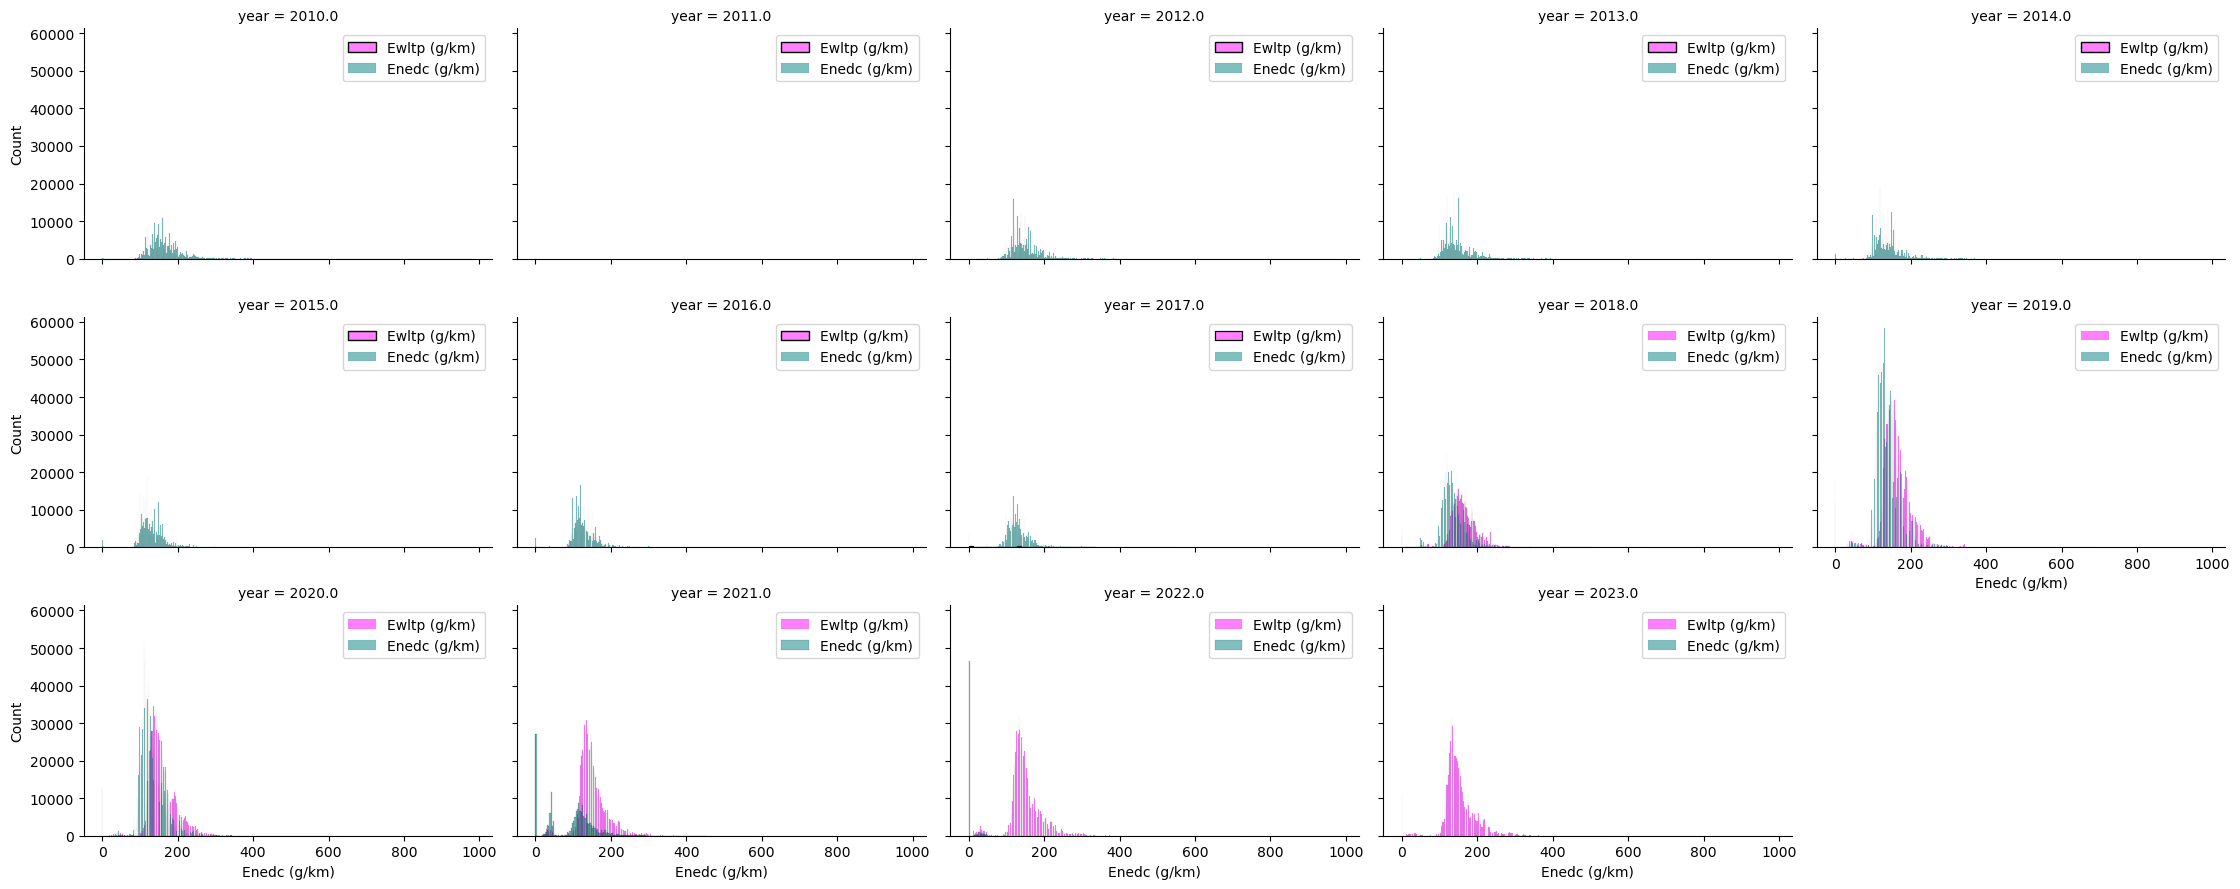

In [173]:
#First version of yearplot w/o function definition

# Create a FacetGrid with 3 rows and 5 columns
g = sns.FacetGrid(df_combustion, col="year", col_wrap=5, height=3, aspect=1.5)

# Map both histograms onto the grid
g.map(sns.histplot, "Ewltp (g/km)", color="magenta", label="Ewltp (g/km)", alpha=0.5)
g.map(sns.histplot, "Enedc (g/km)", color="teal", label="Enedc (g/km)", alpha=0.5)

# Add legend to each subplot
for ax in g.axes.flat:
    ax.legend()

# Show the plot
plt.show()

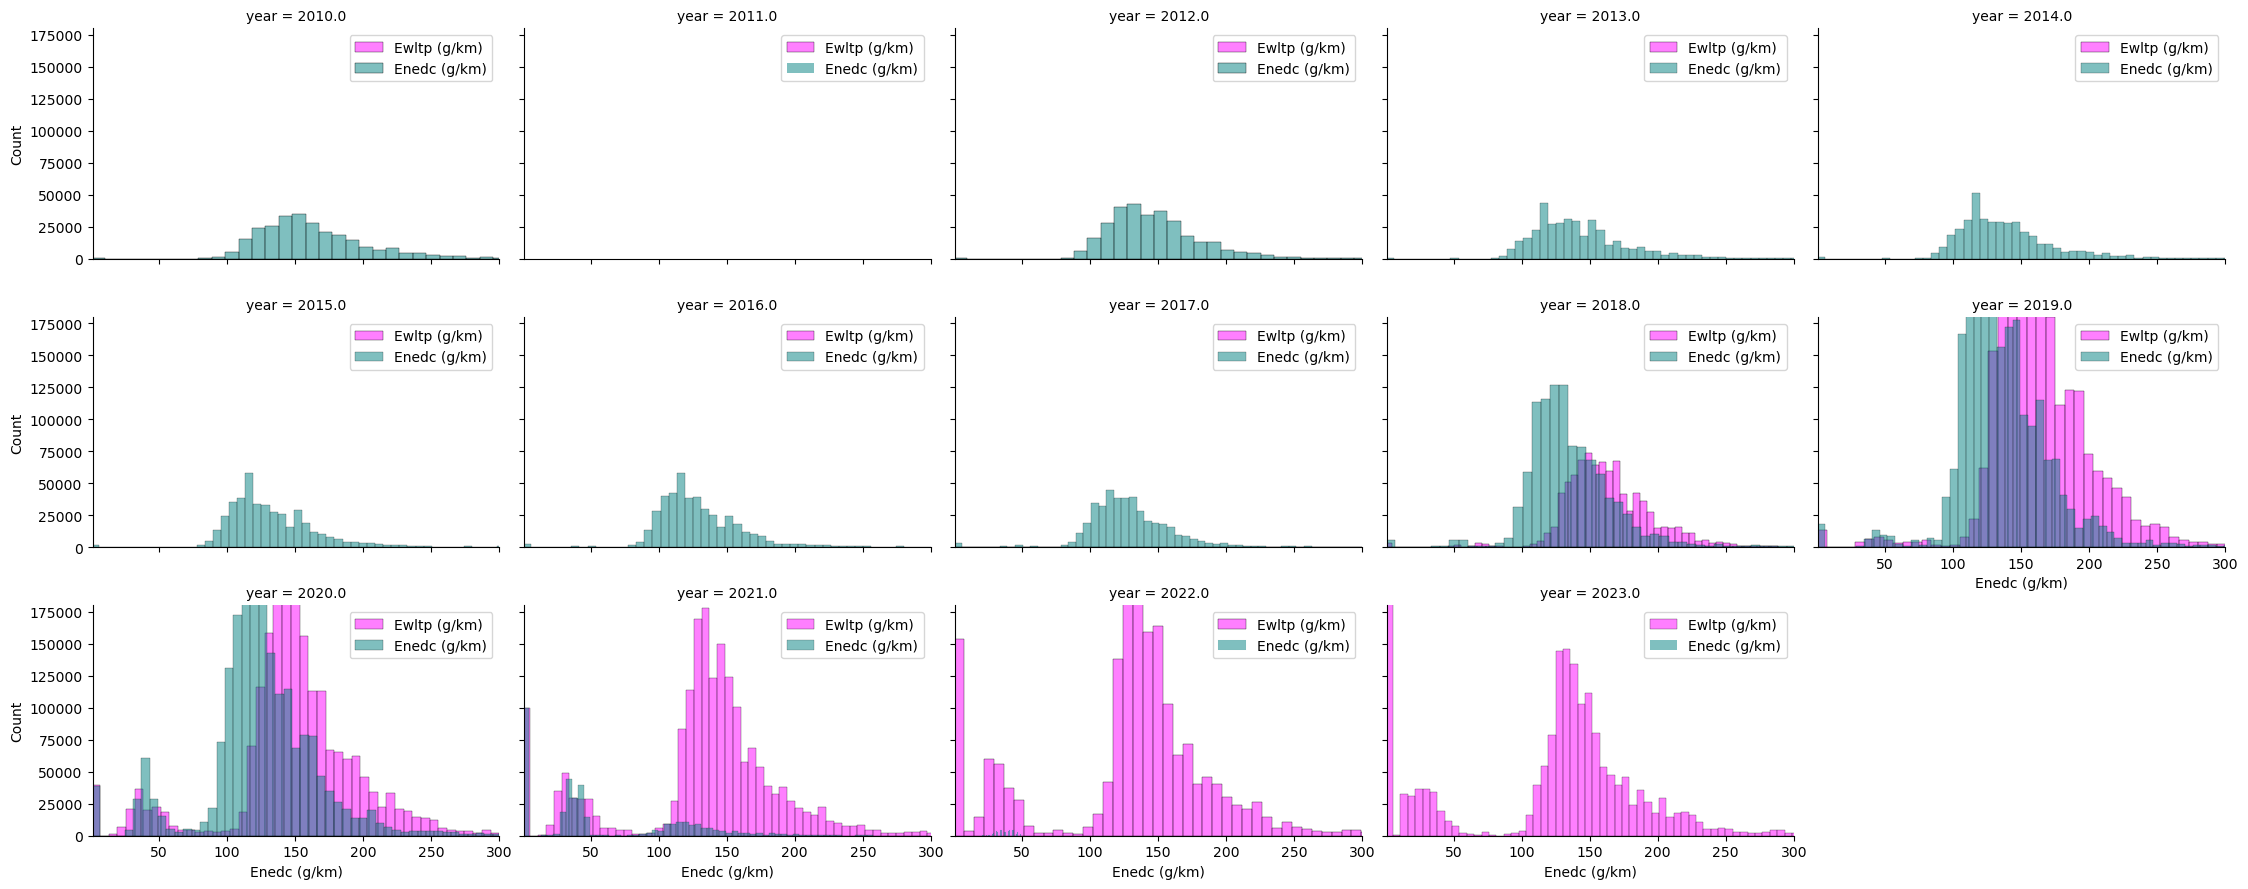

In [177]:
# 2nd, manually refined version (whole df)

# Create a FacetGrid with 3 rows and 5 columns
g = sns.FacetGrid(df, col="year", col_wrap=5, height=3, aspect=1.5)

# Map both histograms onto the grid
g.map(sns.histplot, "Ewltp (g/km)", color="magenta", label="Ewltp (g/km)", bins = 100, kde = False, alpha=0.5)
g.map(sns.histplot, "Enedc (g/km)", color="teal", label="Enedc (g/km)", bins = 100, kde = False, alpha=0.5)

# Add legend and set x-axis limits for each subplot
for ax in g.axes.flat:
    ax.legend()
    ax.set_xlim(1, 300)  # Set x-axis range from 1 to 300
    ax.set_ylim(0, 180000)  # Set y-axis range from 0 to 300

# Show the plot
plt.show()


### TVs with function

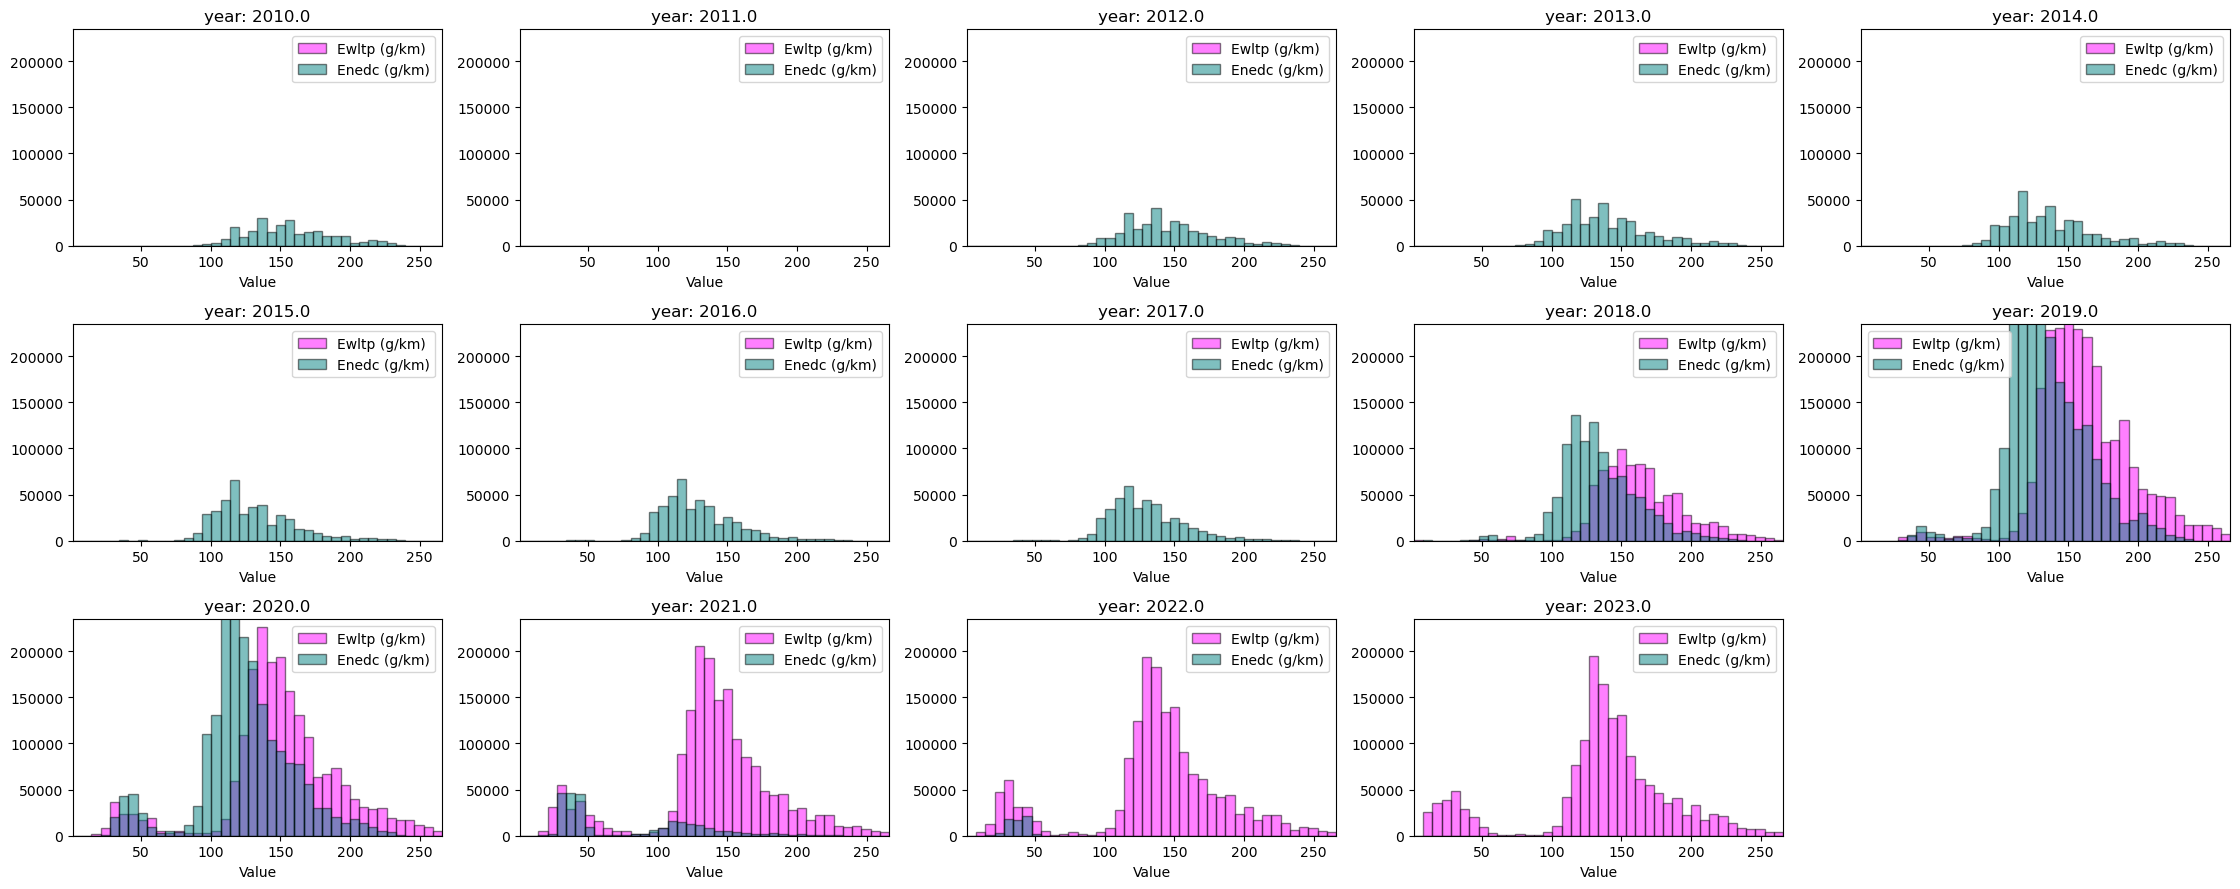

In [59]:
# Generate list of attributes
#excluded_cols = ["ID", "r", "year", "#identical occurences"]
#all_nan_cols = df_combustion.columns[df_combustion.isna().all()].tolist()
attributes =["Ewltp (g/km)", "Enedc (g/km)"]
#attributes = [col for col in df_combustion.select_dtypes(include=['number']).columns 
#              if (col not in excluded_cols) and (col not in all_nan_cols)]

# Call the function with dataframe, attributes, and facet by year
plot_normalized_histograms(df, attributes, row_var="year", bins = 40, palette = ("magenta", "teal"),
                           norm = False, iqrfactor = 2.3, ylimfactor = 0.7)

## Explanatory Variables

### histplot all years

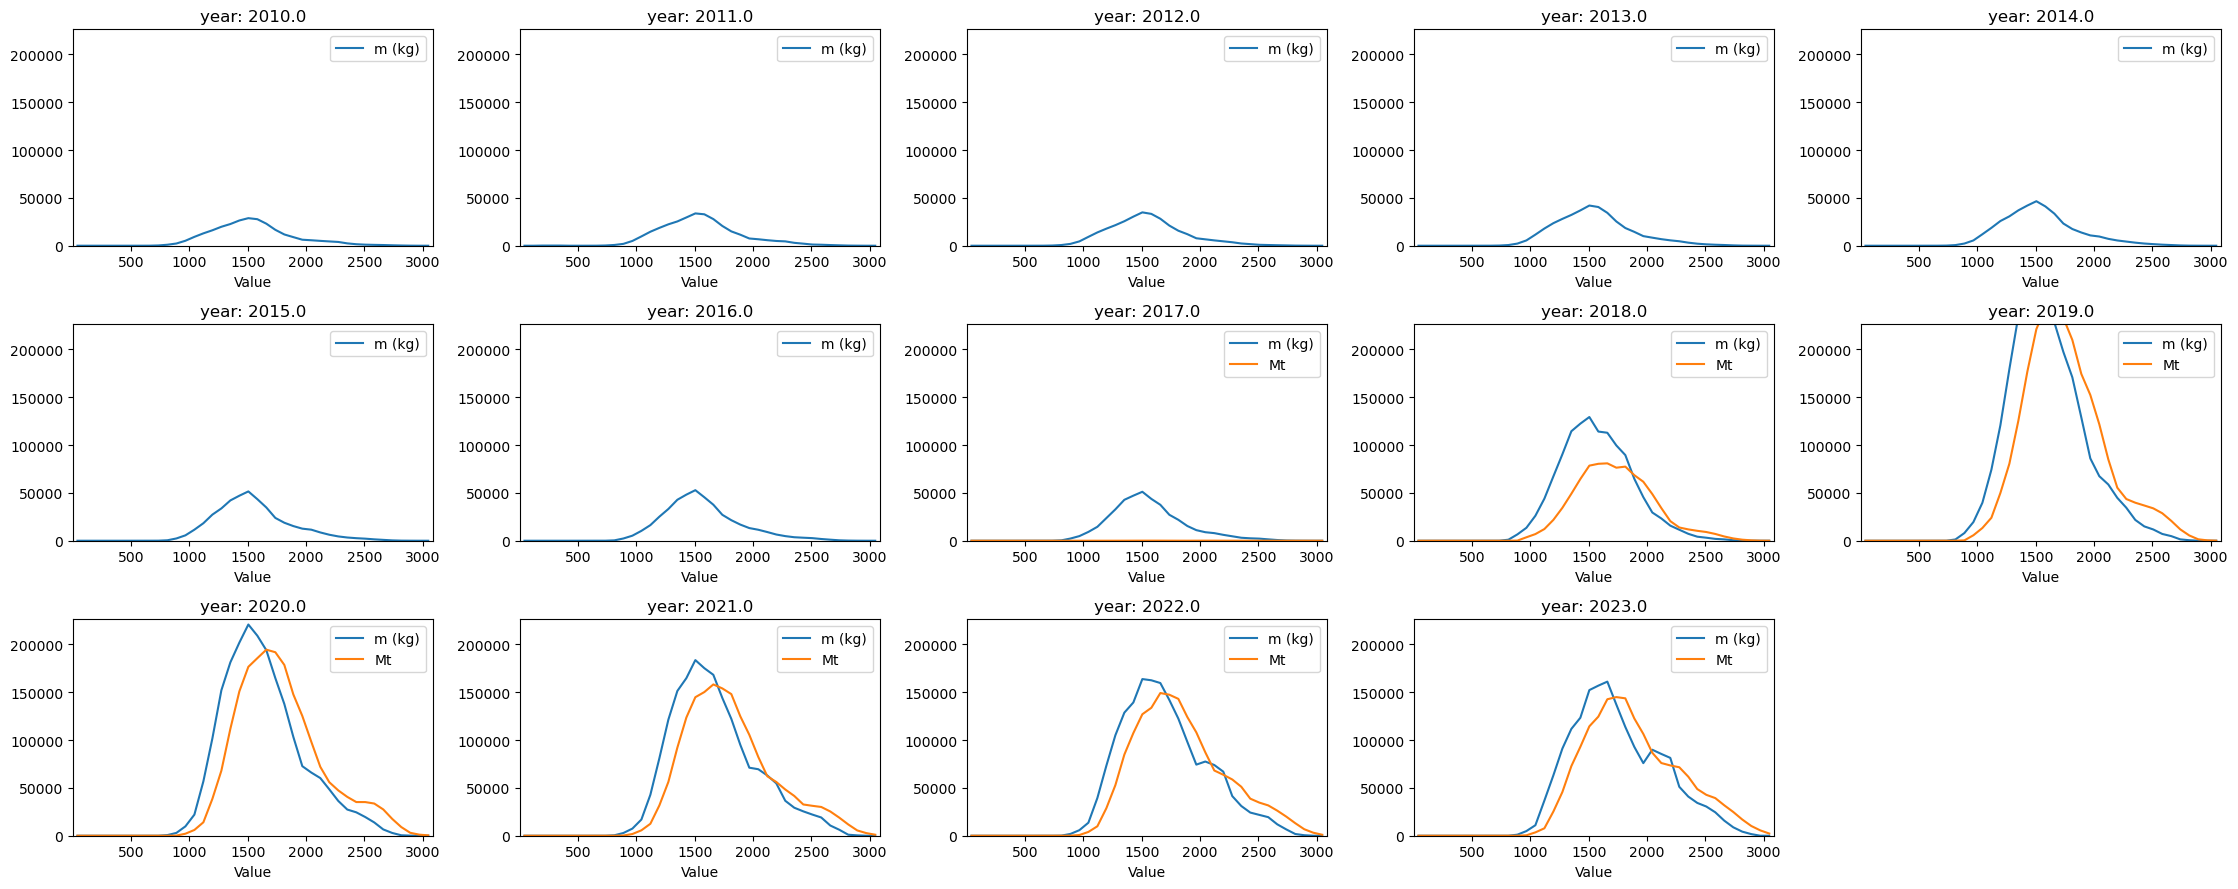

In [70]:
# Generate list of attributes
excluded_cols = ["ID", "r", "year", "#identical occurences"]
all_nan_cols = df.columns[df.isna().all()].tolist()
include_cols =['m (kg)',
 'Mt',
 #'W (mm)',
 #'At1 (mm)',
 #'At2 (mm)',
 #'ec (cm3)',
 #'ep (KW)',
 #'z (Wh/km)'
 ]

attributes = [col for col in include_cols if (col not in excluded_cols) and (col not in all_nan_cols)]

# Call the function with dataframe, attributes, and facet by year
plot_normalized_histograms(df, attributes, row_var="year", bins = 40, norm = False, iqrfactor = 2.3, ylimfactor = 0.7, plot_type="line")

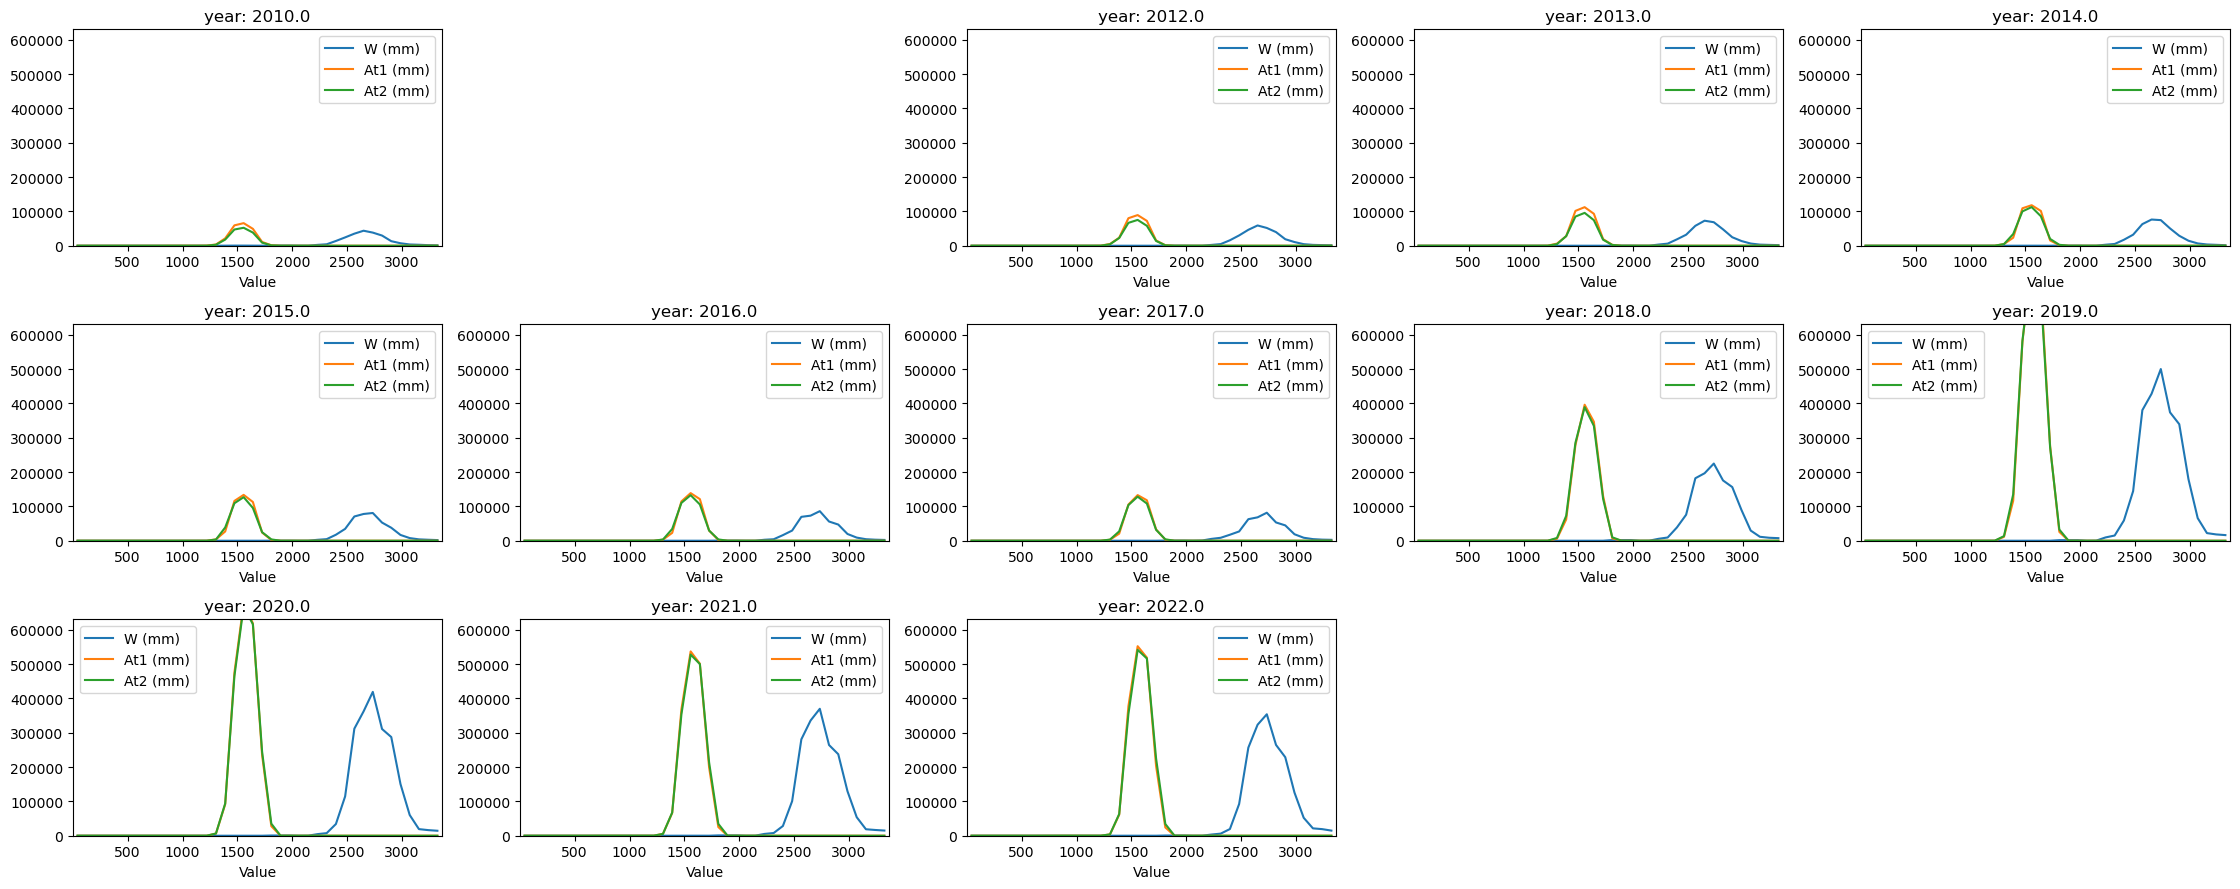

In [71]:
# Generate list of attributes
excluded_cols = ["ID", "r", "year", "#identical occurences"]
all_nan_cols = df.columns[df.isna().all()].tolist()
include_cols =[#'m (kg)',
 #'Mt',
 'W (mm)',
 'At1 (mm)',
 'At2 (mm)',
 #'ec (cm3)',
 #'ep (KW)',
 #'z (Wh/km)'
 ]

attributes = [col for col in include_cols if (col not in excluded_cols) and (col not in all_nan_cols)]

# Call the function with dataframe, attributes, and facet by year
plot_normalized_histograms(df, attributes, row_var="year", bins = 40, norm = False, iqrfactor = 2.3, ylimfactor = 0.7, plot_type="line")

### f: count missing values

In [179]:
import pandas as pd
import numpy as np

def count_missing_values(df):
    missing_counts = {}
    
    for col in df.columns:
        # Count pd.NA and np.nan separately
        pd_na_count = df[col].isna().sum() if df[col].dtype.name == 'category' else 0
        np_nan_count = df[col].isna().sum() if df[col].dtype.name == 'float32' else 0
        
        # Store the results
        missing_counts[col] = {'pd.NA': pd_na_count,
                               'np.nan': np_nan_count,
                               'Dtype': df[col].dtype.name,
                               'Percent Missing': f"{df[col].isna().sum() / len(df[col]) * 100:.2f}%"
}

    
    # Convert the results to a DataFrame for easier viewing
    result_df = pd.DataFrame(missing_counts).T
    return result_df

#### execute f: count missing 

In [95]:
# Count and display the missing values
result = count_missing_values(df)
print(result)


                          pd.NA    np.nan     Dtype Percent Missing
ID                            0         0   float32           0.00%
Country                       0         0  category           0.00%
VFN                     6022343         0  category          41.70%
Mp                      1538457         0  category          10.65%
Mh                            0         0  category           0.00%
Man                      310768         0  category           2.15%
MMS                     6048284         0  category          41.88%
Tan                      490543         0  category           3.40%
T                         62037         0  category           0.43%
Va                       100484         0  category           0.70%
Ve                       225223         0  category           1.56%
Mk                        42908         0  category           0.30%
Cn                        49370         0  category           0.34%
Ct                        24689         0  categ

### f: barchart non_nan_counts 

In [178]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_non_nan_counts(df, attributes, row_var, col_wrap=5, height=3, aspect=1.5):
    """
    Plots multiple bar charts showing the count of non-NaN values for each attribute per year.
    
    Parameters:
    - df: The DataFrame containing the data.
    - attributes: A list of column names (attributes) to plot.
    - row_var: The column used to facet the data (e.g., 'year').
    - col_wrap: Number of columns per row in the grid (default is 5).
    - height: Height of each subplot (default is 3).
    - aspect: Aspect ratio of each subplot (default is 1.5).
    """
    
    # Melt the dataframe to long format for easy aggregation and plotting
    df_long = df.melt(id_vars=[row_var], value_vars=attributes, var_name='attribute', value_name='value')
    
    # Group by the row_var (e.g., 'year') and attribute, then count non-NaN values
    df_counts = df_long.groupby([row_var, 'attribute']).value.count().reset_index()
    df_counts.rename(columns={'value': 'non_nan_count'}, inplace=True)
    
    # Define the order of attributes for consistency
    attribute_order = sorted(attributes)
    
    # Create the FacetGrid with hue set to 'attribute' and assign the palette accordingly
    g = sns.FacetGrid(
        df_counts,
        col=row_var,
        hue='attribute',
        col_wrap=col_wrap,
        height=height,
        aspect=aspect,
        palette='tab20',   # other good ones :tab20 (for good discernability)
        sharey=False
    )
    
    # Map the barplot onto the FacetGrid
    g.map_dataframe(
        sns.barplot,
        x='attribute',
        y='non_nan_count',
        order=attribute_order,
        dodge=False
    )
    
    # Add numerical labels and legend to each subplot
    #for ax in g.axes.flat:
    #    for container in ax.containers:
    #        ax.bar_label(container, fmt='%d', label_type='edge')
    #    ax.legend(title='Attribute', frameon=True)
    
    # Remove x-axis labels and tick labels for all plots since we have a legend
    for ax in g.axes.flat:
        ax.set_xlabel('')            # Remove x-axis label
        ax.set_xticklabels([])       # Remove x-axis tick labels

    
    # Extract handles and labels from the first Axes
    handles, labels = g.axes.flat[0].get_legend_handles_labels()
    
    # Add a single, consolidated legend to the figure in the lower right corner with a frame
    g.figure.legend(handles, labels, title='Attribute', loc='lower right', frameon=True)
    
    # Adjust layout to make room for the legend
    g.figure.subplots_adjust(right=0.85)
    
    # Improve layout spacing
    plt.tight_layout()
    
    # Display the plot
    plt.show()

#### plot barchart(s)

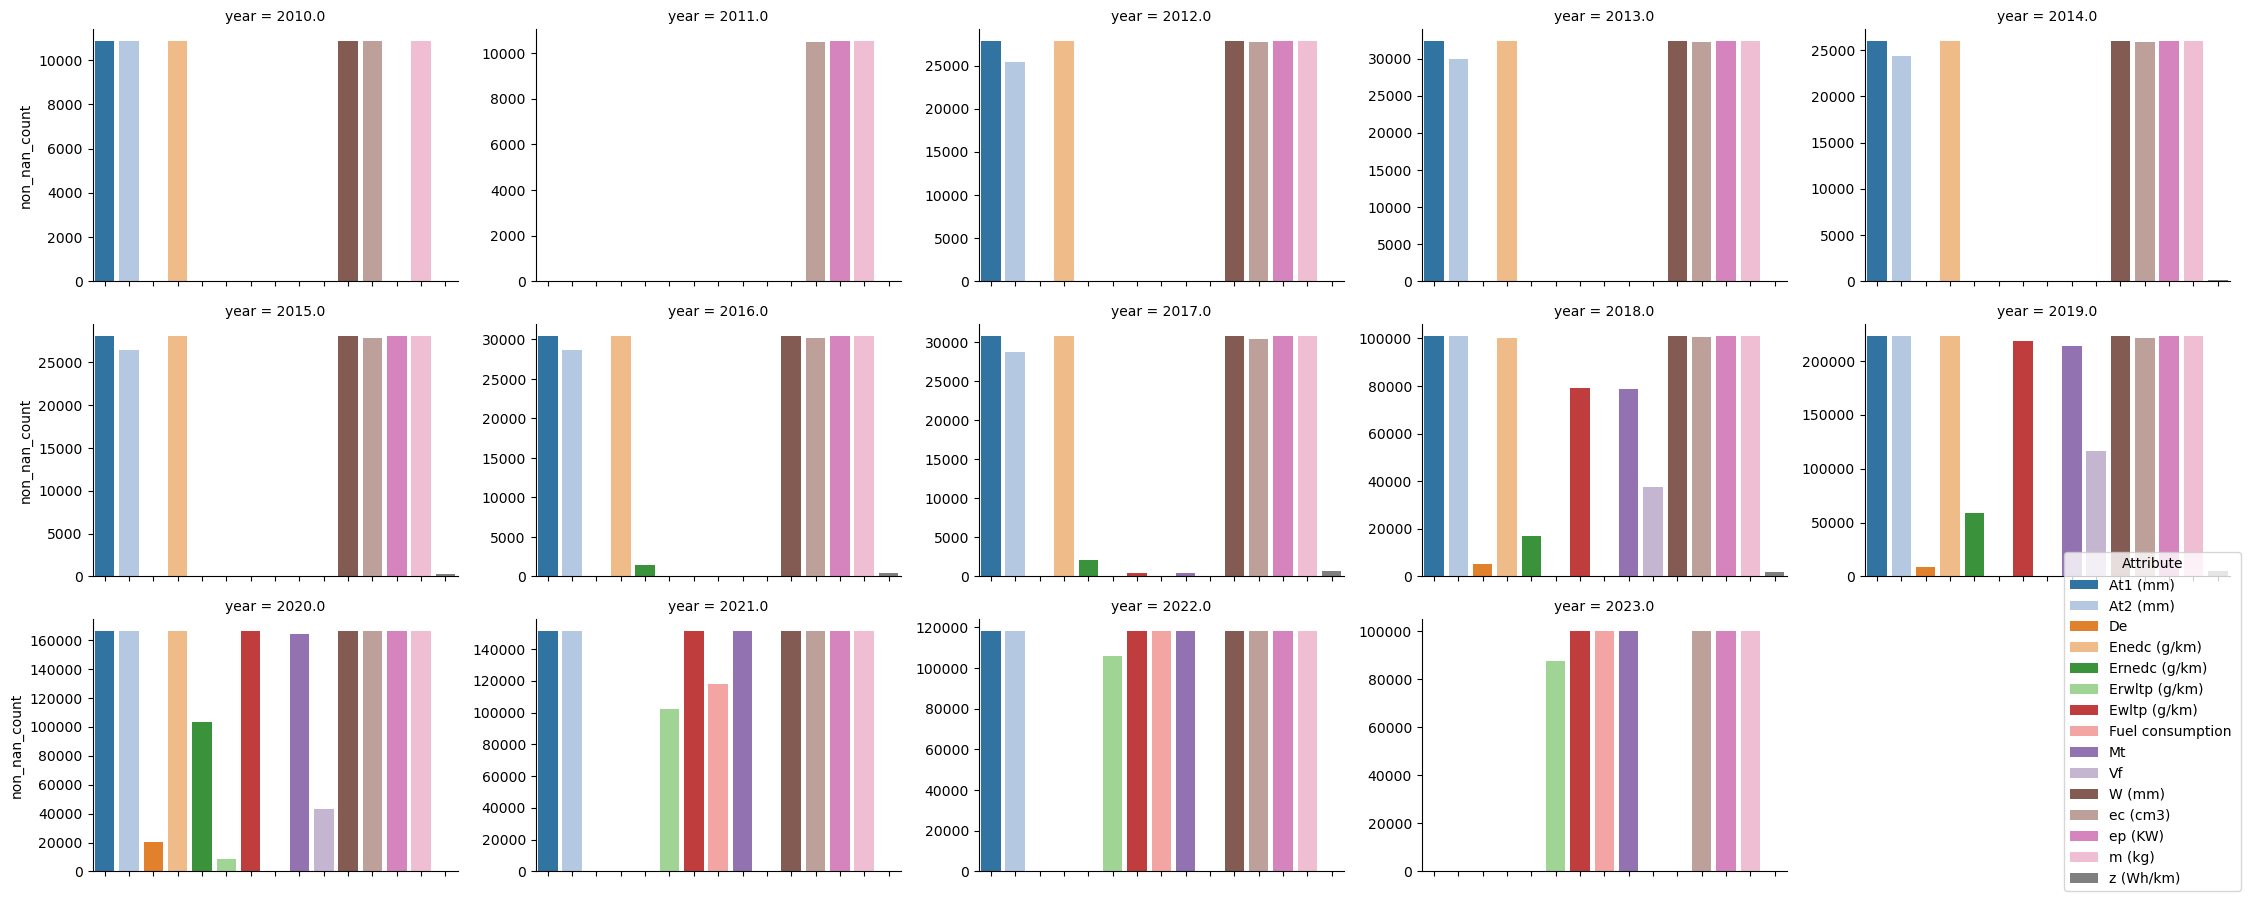

In [77]:
excluded_cols = ["ID", "r", "year", "#identical occurences"]
all_nan_cols = df_combustion.columns[df_combustion.isna().all()].tolist()
attributes = [col for col in df_combustion.select_dtypes(include=['number']).columns 
              if (col not in excluded_cols) and (col not in all_nan_cols)]

# For demonstration, using the provided attributes
#attributes = ["Ewltp (g/km)", "Enedc (g/km)"]

# Call the function with dataframe, attributes, and facet by year
# Ensure that df_combustion and "year" column exist in your DataFrame
plot_non_nan_counts(df_combustion, attributes, row_var="year")

# Clean Columns

### Read previously shared DataFrame

In [ ]:
df = pd.read_parquet(parquet_EU_shared)

In [7]:
# First, let's inspect the unique categories in each categorical column
for col in df.select_dtypes(include=['category']):
    num_categories = df[col].nunique(dropna=False)
    print(f"Column '{col}' has {num_categories} unique categorical values (including NaN).")

Column 'Country' has 31 unique categorical values (including NaN).
Column 'VFN' has 29049 unique categorical values (including NaN).
Column 'Mp' has 47 unique categorical values (including NaN).
Column 'Mh' has 261 unique categorical values (including NaN).
Column 'Man' has 478 unique categorical values (including NaN).
Column 'MMS' has 11562 unique categorical values (including NaN).
Column 'Tan' has 49910 unique categorical values (including NaN).
Column 'T' has 26612 unique categorical values (including NaN).
Column 'Va' has 72534 unique categorical values (including NaN).
Column 'Ve' has 182641 unique categorical values (including NaN).
Column 'Mk' has 1746 unique categorical values (including NaN).
Column 'Cn' has 80815 unique categorical values (including NaN).
Column 'Ct' has 17 unique categorical values (including NaN).
Column 'Cr' has 9 unique categorical values (including NaN).
Column 'Ft' has 55 unique categorical values (including NaN).
Column 'Fm' has 15 unique categorical

### Function to Rename Categorical Values

In [8]:
# Function to rename categorical values using mappings
def rename_catval(df, attribute, mappings):
    """
    Rename categorical values in a DataFrame column based on provided mappings.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the column to be renamed.
    attribute (str): The name of the column to be renamed.
    mappings (list of tuples): Each tuple contains a list of aliases and the target name.
                               Example: [ (['old_name1', 'old_name2'], 'new_name'), ... ]
    """
    # Convert the column to a non-categorical type (e.g., string)
    df[attribute] = df[attribute].astype('string')

    # Build a rename dictionary from the mappings
    rename_dict = {}
    for aliases, target_name in mappings:
        for alias in aliases:
            rename_dict[alias] = target_name

    # Replace values
    df[attribute] = df[attribute].replace(rename_dict)

    # Convert the column back to categorical
    df[attribute] = df[attribute].astype('category')

### **Ct Column (Category of the vehicle type approved)**

In [11]:
# Inspect the categories and value counts of 'Ct'
print(df.Ct.cat.categories)
df.Ct.value_counts()

Index([' ', '  ', 'M1', 'M1 ', 'M1  ', 'M1G', 'M1G ', 'M2 ', 'N1', 'N1 ',
       'N1G', 'N2', 'N2G', 'N3', 'N3G', 'm1'],
      dtype='object')


M1      13191645
M1G       988772
M1        189244
M1         20165
m1         15709
N1          7752
M1G         4550
N1G          114
N2            73
N1            27
              20
N3            19
N2G           10
               1
M2             1
N3G            1
Name: Ct, dtype: int64

In [13]:
df[df.Ct == 'm1'].year.value_counts()

2017.0    15705
2021.0        4
Name: year, dtype: int64

In [24]:
df[df["year"] == 2017].Ct.value_counts()

M1      395054
m1       15705
M1G       9261
M1        4077
N1          35
N2           9
N1G          2
             0
             0
M1           0
M1G          0
M2           0
N1           0
N2G          0
N3           0
N3G          0
Name: Ct, dtype: int64

as it appears basically only in one year, "m1" seems to be a misspelling as well ==> rename to "M1"

In [25]:
# Define mappings for 'Ct'
mappings_ct = [
    ([' ', '  '], pd.NA),
    (['M1 ', 'M1  ', 'm1'], 'M1'),
    (['M1G '], 'M1G'),
    (['M2 '], 'M2'),
    (['N1 '], 'N1'),
]

# Apply the renaming to the 'Ct' column
rename_catval(df, "Ct", mappings_ct)
print(df.Ct.cat.categories)
df.Ct.value_counts()

Index(['M1', 'M1G', 'M2', 'N1', 'N1G', 'N2', 'N2G', 'N3', 'N3G'], dtype='string')


M1     13416763
M1G      993322
N1         7779
N1G         114
N2           73
N3           19
N2G          10
M2            1
N3G           1
Name: Ct, dtype: int64

### **Cr Column (Category of the vehicle registered)**

In [26]:
# Inspect the categories and value counts of 'Cr'
print(df.Cr.cat.categories)
df.Cr.value_counts()
df[df.Cr == 'm1'].year.value_counts()

Index([' ', 'M1', 'M1 ', 'M1  ', 'M1G', 'M1G ', 'M1S', 'm1'], dtype='object')


2019.0    236
2021.0      5
2018.0      2
Name: year, dtype: int64

In [29]:
df[df.Cr == 'M1S'].year.value_counts()

2022.0    19
Name: year, dtype: int64

only one year ==> probably misspelling of "M1G"

In [30]:
# Define mappings for 'Cr'
mappings_cr = [
    ([' ', '  '], pd.NA),
    (['M1 ', 'M1  ', 'm1'], 'M1'),
    (['M1G ', 'M1S'], 'M1G'),
]

# Apply the renaming to the 'Cr' column
rename_catval(df, "Cr", mappings_cr)
print(df.Cr.cat.categories)
df.Cr.value_counts()

Index(['M1', 'M1G'], dtype='string')


M1     10687330
M1G      928709
Name: Cr, dtype: int64

### **Fm (Fuel Mode) Column**

In [31]:
# Inspect the categories and value counts of 'Fm'
print(df.Fm.cat.categories)
df.Fm.value_counts()

Index(['2', 'Alimentazione Sconosciuta', 'B', 'E', 'F', 'F  ', 'H', 'M', 'M  ',
       'P', 'h', 'm', 'na', 'p'],
      dtype='object')


M                            11486700
H                             1370724
P                              886030
E                              538105
B                               65385
F                                7513
na                               5194
M                                2229
m                                 188
F                                  18
p                                  17
2                                   7
h                                   3
Alimentazione Sconosciuta           1
Name: Fm, dtype: int64

In [32]:
df[df.Fm == 'na'].Country.value_counts()

NL    5059
IT      95
DE      32
MT       5
RO       2
FI       1
AT       0
SK       0
SI       0
SE       0
PT       0
PL       0
NO       0
LV       0
LU       0
LT       0
IE       0
IS       0
BE       0
HU       0
HR       0
GR       0
GB       0
FR       0
ES       0
EE       0
DK       0
CZ       0
CY       0
BG       0
UK       0
Name: Country, dtype: int64

In [33]:
df[df["Fm"].isna()]["Country"].value_counts()

NL    44926
ES    29351
MT     2886
BG     2717
PL      528
BE      129
DE       89
UK       11
FI       10
RO        6
CY        6
SK        5
LU        4
IT        3
GB        2
PT        2
DK        1
GR        1
SE        1
SI        0
NO        0
AT        0
LV        0
LT        0
IS        0
HU        0
HR        0
FR        0
EE        0
CZ        0
IE        0
Name: Country, dtype: int64

"na"concentrated in the Netherlands where there is a lot of pd.NA ==> treat "na" as pd.NA

In [34]:
# Define mappings for 'Fm'
mappings_fm = [
    (['na', 'Alimentazione Sconosciuta', '2'], pd.NA),
    (['F  '], 'F'),
    (['M  ', 'm'], 'M'),
    (['h'], 'H'),
    (['p'], 'P'),
]

# Apply the renaming to the 'Fm' column
rename_catval(df, "Fm", mappings_fm)
print(df.Fm.cat.categories)
df.Fm.value_counts()

Index(['B', 'E', 'F', 'H', 'M', 'P'], dtype='string')


M    11489117
H     1370727
P      886047
E      538105
B       65385
F        7531
Name: Fm, dtype: int64

### **Ft (Fuel Type) Column**

In [35]:
# Inspect the categories and value counts of 'Ft'
print(df.Ft.cat.categories)
df.Ft.value_counts()

Index([' ', 'BIODIESEL', 'Biodiesel', 'DIESEL', 'DIESEL                   ',
       'DIESEL-ELECTRIC', 'DIESEL/ELECTRIC', 'Diesel', 'Diesel-Electric',
       'Diesel-electric', 'Diesel/Electric', 'Diesel/electric', 'E85',
       'ELECTRIC', 'Electric', 'Electric                 ', 'HYDROGEN',
       'Hydrogen', 'LPG', 'LPG                      ', 'NG', 'NG-BIOMETHANE',
       'NG-Biomethane', 'NG-biomethane', 'NG-biomethane            ',
       'NG_biomethane', 'OTHER', 'Other', 'PETROL', 'PETROL ',
       'PETROL                   ', 'PETROL-ELECTRIC', 'PETROL/ELECTRIC',
       'Petrol', 'Petrol ', 'Petrol-Electric', 'Petrol-Gas', 'Petrol-electric',
       'Petrol/Electric', 'UNKNOWN', 'diesel', 'diesel-electric',
       'diesel/electric', 'e85', 'electric', 'hydrogen', 'lpg', 'ng',
       'ng-biomethane', 'petrol', 'petrol ', 'petrol-electric',
       'petrol/electric', 'unknown'],
      dtype='object')


PETROL                       3322376
DIESEL                       2945617
petrol                       2228168
diesel                       2003718
Diesel                       1320232
Petrol                       1006352
PETROL/ELECTRIC               550171
ELECTRIC                      296497
petrol/electric               266837
electric                      233016
DIESEL/ELECTRIC                53038
LPG                            40570
diesel/electric                25681
NG                             18718
                               16995
lpg                            14985
Petrol/Electric                14454
DIESEL                         12494
Electric                       11011
E85                             8766
NG-biomethane                   8720
ng                              8593
NG-BIOMETHANE                   6440
PETROL                          6059
ng-biomethane                   4058
Petrol-electric                 3371
e85                             2391
p

In [36]:
# Define mappings for 'Ft'
mappings_ft = [
    # Map 'PETROL' variants
    ([
        'PETROL', 'PETROL ', 'PETROL                   ', 'Petrol', 'Petrol ', 'petrol', 'petrol ', 'Petrol-Gas'
    ], 'PETROL'),
    # Map 'DIESEL' variants
    ([
        'DIESEL', 'DIESEL                   ', 'Diesel', 'diesel'
    ], 'DIESEL'),
    # Map 'PETROL/ELECTRIC' variants
    ([
        'PETROL-ELECTRIC', 'PETROL/ELECTRIC', 'Petrol-Electric', 'Petrol-electric',
        'Petrol/Electric', 'petrol-electric', 'petrol/electric'
    ], 'PETROL/ELECTRIC'),
    # Map 'DIESEL/ELECTRIC' variants
    ([
        'DIESEL-ELECTRIC', 'DIESEL/ELECTRIC', 'Diesel-Electric', 'Diesel-electric',
        'Diesel/Electric', 'Diesel/electric', 'diesel-electric', 'diesel/electric'
    ], 'DIESEL/ELECTRIC'),
    # Map 'ELECTRIC' variants
    ([
        'ELECTRIC', 'Electric', 'Electric                 ', 'electric'
    ], 'ELECTRIC'),
    # Map 'LPG' variants
    ([
        'LPG', 'LPG                      ', 'lpg'
    ], 'LPG'),
    # Map 'NG-BIOMETHANE' variants
    ([
        'NG-BIOMETHANE', 'NG-Biomethane', 'NG-biomethane', 'NG-biomethane            ',
        'NG_biomethane', 'ng-biomethane', 'NG', 'ng'
    ], 'NG-BIOMETHANE'),
    # Map 'HYDROGEN' variants
    ([
        'HYDROGEN', 'Hydrogen', 'hydrogen'
    ], 'HYDROGEN'),
    # Map 'E85' variants
    ([
        'E85', 'e85'
    ], 'E85'),
    # Map 'BIODIESEL' variants
    ([
        'BIODIESEL', 'Biodiesel'
    ], 'BIODIESEL'),
    # Map 'OTHER' variants
    ([
        'OTHER', 'Other'
    ], 'OTHER'),
    # Map unknown variants to pd.NA
    ([
        'UNKNOWN', 'unknown', ' '
    ], pd.NA),
]

# Apply the renaming to the 'Ft' column
rename_catval(df, "Ft", mappings_ft)
print(df.Ft.cat.categories)
df.Ft.value_counts(dropna=False)

Index(['BIODIESEL', 'DIESEL', 'DIESEL/ELECTRIC', 'E85', 'ELECTRIC', 'HYDROGEN',
       'LPG', 'NG-BIOMETHANE', 'OTHER', 'PETROL', 'PETROL/ELECTRIC'],
      dtype='string')


PETROL             6563371
DIESEL             6282061
PETROL/ELECTRIC     837545
ELECTRIC            540712
DIESEL/ELECTRIC      80397
LPG                  55900
NG-BIOMETHANE        46859
NaN                  24373
E85                  11157
HYDROGEN               314
BIODIESEL               94
OTHER                    9
Name: Ft, dtype: int64

### **Country Column**

In [37]:
# Inspect the categories and value counts of 'Country'
print(df.Country.cat.categories)
df.Country.value_counts(dropna=False)

Index(['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB',
       'GR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LT', 'LU', 'LV', 'MT', 'NL', 'NO',
       'PL', 'PT', 'RO', 'SE', 'SI', 'SK', 'UK'],
      dtype='object')


DE    4543321
FR    1205514
IT    1015799
BE     953725
GB     806369
AT     740210
PL     706497
ES     705075
NL     453097
SE     400220
CZ     382540
LU     261769
SK     258416
HU     225802
DK     218723
PT     211956
FI     206949
RO     189734
SI     154920
GR     140088
IE     108558
BG      91622
LT      74733
EE      71633
HR      69821
UK      60569
NO      57066
LV      56635
MT      37243
CY      25292
IS       8896
Name: Country, dtype: int64

In [38]:
# Check GB and UK
print("UK:", df[df.Country == "UK"].year.value_counts())
print("GB:", df[df.Country == "GB"].year.value_counts())

UK: 2010.0    60569
Name: year, dtype: int64
GB: 2019.0    203328
2020.0    147335
2018.0    107083
2011.0     59294
2012.0     58269
2016.0     48916
2017.0     48504
2013.0     45627
2014.0     44746
2015.0     43267
Name: year, dtype: int64


GB and UK are complementary ==> rename all to UK

In [39]:
# Define mappings for 'Country'
mappings_country = [
    (['GB'], 'UK'),
]

# Apply the renaming to the 'Country' column
rename_catval(df, "Country", mappings_country)
print(df.Country.cat.categories)
df.Country.value_counts()

Index(['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GR',
       'HR', 'HU', 'IE', 'IS', 'IT', 'LT', 'LU', 'LV', 'MT', 'NL', 'NO', 'PL',
       'PT', 'RO', 'SE', 'SI', 'SK', 'UK'],
      dtype='string')


DE    4543321
FR    1205514
IT    1015799
BE     953725
UK     866938
AT     740210
PL     706497
ES     705075
NL     453097
SE     400220
CZ     382540
LU     261769
SK     258416
HU     225802
DK     218723
PT     211956
FI     206949
RO     189734
SI     154920
GR     140088
IE     108558
BG      91622
LT      74733
EE      71633
HR      69821
NO      57066
LV      56635
MT      37243
CY      25292
IS       8896
Name: Country, dtype: int64

#### optional: rename to full country names

In [ ]:
# optional: rename to full country names

rename_dict = {
    'AT': 'Austria',
    'BE': 'Belgium',
    'BG': 'Bulgaria',
    'CY': 'Cyprus',
    'CZ': 'Czech Republic',
    'DE': 'Germany',
    'DK': 'Denmark',
    'EE': 'Estonia',
    'ES': 'Spain',
    'FI': 'Finland',
    'FR': 'France',
    'GB': 'United Kingdom',  # 'GB' often refers to the UK
    'GR': 'Greece',
    'HR': 'Croatia',
    'HU': 'Hungary',
    'IE': 'Ireland',
    'IS': 'Iceland',
    'IT': 'Italy',
    'LT': 'Lithuania',
    'LU': 'Luxembourg',
    'LV': 'Latvia',
    'MT': 'Malta',
    'NL': 'Netherlands',
    'NO': 'Norway',
    'PL': 'Poland',
    'PT': 'Portugal',
    'RO': 'Romania',
    'SE': 'Sweden',
    'SI': 'Slovenia',
    'SK': 'Slovakia',
    'UK': 'United Kingdom'  # Mapping 'UK' to 'United Kingdom' as well
}

rename_catval(df,"Country",rename_dict)

### Mp (work in progress / not yet cleaned)

In [40]:
print(df.Mp.cat.categories)
df.Mp.value_counts()

Index(['BMW', 'BMW GROUP', 'DAIMLER AG', 'FCA', 'FCA ITALY SPA', 'FCA-TESLA',
       'FIAT GROUP AUTOMOBILES SPA', 'FORD', 'FORD POOL', 'FORD-WERKE GMBH',
       'GENERAL MOTORS', 'HONDA MOTOR EUROPE LTD', 'HYUNDAI',
       'HYUNDAI MOTOR EUROPE', 'JLT POOL', 'KG MOBILITY GREAT WALL MOTOR',
       'KIA', 'MAZDA', 'MAZDA-SUBARU-SUZUKI-TOYOTA', 'MERCEDES-BENZ',
       'MERCEDES-BENZ AG', 'MG-SAIC', 'MITSUBISHI MOTORS', 'MITSUBISHI POOL',
       'POOL RENAULT', 'PSA', 'PSA-OPEL', 'RENAULT', 'RENAULT-MITSUBISHI',
       'RENAULT-NISSAN-MITSUBISHI', 'STELLANTIS', 'SUBARU-SUZUKI-TOYOTA',
       'SUZUKI', 'SUZUKI POOL', 'TATA MOTORS JAGUAR LAND ROVER',
       'TATA MOTORS LTD, JAGUAR CARS LTD , LAND ROVER',
       'TATA MOTORS LTD, JAGUAR CARS LTD, LAND ROVER', 'TESLA',
       'TESLA-HONDA-JLR', 'TOYOTA -DAIHATSU GROUP', 'TOYOTA-DAHAITSU GROUP',
       'TOYOTA-MAZDA', 'VOLKSWAGEN', 'VW GROUP PC', 'VW-SAIC', 'na'],
      dtype='object')


VOLKSWAGEN                                       2446297
VW GROUP PC                                      1938866
BMW                                              1133403
BMW GROUP                                         827705
VW-SAIC                                           792555
MERCEDES-BENZ                                     768198
DAIMLER AG                                        750495
STELLANTIS                                        514750
PSA-OPEL                                          444418
FORD-WERKE GMBH                                   402987
FORD                                              378882
RENAULT-NISSAN-MITSUBISHI                         264594
MERCEDES-BENZ AG                                  258285
RENAULT                                           233984
GENERAL MOTORS                                    214183
PSA                                               201674
KIA                                               134935
RENAULT-MITSUBISHI             

In [ ]:
print("BMW:", df[df.Mp == "BMW"].year.value_counts())
print("BMW Group:", df[df.Mp == "BMW GROUP"].year.value_counts())

BMW: 2020.0    313534
2021.0    279976
2023.0    273216
2022.0    266677
Name: year, dtype: int64
BMW Group: 2019.0    366517
2018.0    240755
2015.0     44812
2017.0     44687
2016.0     42786
2014.0     35780
2013.0     29066
2012.0     23302
Name: year, dtype: int64


In [ ]:
print(df.Mp.cat.categories)
df.Mp.value_counts()

## Save cleaned Dataframe

In [42]:
df.to_parquet("..\\Data\\EU\\shared\\EU all_current_shared.parquet")

In [43]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14442792 entries, 0 to 14442791
Data columns (total 41 columns):
 #   Column                 Non-Null Count     Dtype   
---  ------                 --------------     -----   
 0   ID                     14442792 non-null  float32 
 1   Country                14442792 non-null  category
 2   VFN                    8420449 non-null   category
 3   Mp                     12904335 non-null  category
 4   Mh                     14442792 non-null  category
 5   Man                    14132024 non-null  category
 6   MMS                    8394508 non-null   category
 7   Tan                    13952249 non-null  category
 8   T                      14380755 non-null  category
 9   Va                     14342308 non-null  category
 10  Ve                     14217569 non-null  category
 11  Mk                     14399884 non-null  category
 12  Cn                     14393422 non-null  category
 13  Ct                     14418082 non-null

# Create tvv and explore

In [214]:
# Convert the column to a non-categorical type (e.g., string)
df["T"] = df["T"].astype('string')
df["Va"] = df["Va"].astype('string')
df["Ve"] = df["Ve"].astype('string')

# create ew column from combining T + Va + Ve
df["tvv"] = df["T"] + df["Va"] + df["Ve"]

# Convert the column back to categorical if needed
df["T"] = df["T"].astype('category')
df["Va"] = df["Va"].astype('category')
df["Ve"] = df["Ve"].astype('category')
df["tvv"] = df["tvv"].astype('category')

In [215]:
df.tvv.nunique()

394986

In [219]:
df.tvv.value_counts()[:2000]

F2AX203T2EZAA151B                          12335
FMX21BSIAW50000                            10315
G3X61DPIAW50000                            10218
G5XTA61IAA5090A                             9312
G4C71AW0AC50000                             8837
                                           ...  
FPHNST-F11E01                                988
FYSDRYAQ1QD7AD7DK002RT61B184BIAEM8FSB30      988
F4DGZT-R1E000                                988
G5XTH41IAE509BA                              987
ACYHZR-C2F000                                987
Name: tvv, Length: 2000, dtype: int64

In [227]:
df[df["T"].notna() & df["Va"].notna() & df["Ve"].notna()].tvv.nunique()

394986

In [228]:
df[df["T"].notna() & df["Va"].notna() & df["Ve"].isna()].tvv.nunique()

0

In [242]:
df[df["T"].isna() | df["Va"].isna() | df["Ve"].isna()].shape[0]

245331

In [249]:
# df of rows with at least one of T, Va, Ve missing (tvv not calculated)
df_tvv_miss = df[df["T"].isna() | df["Va"].isna() | df["Ve"].isna()]

In [250]:
# are specific coutries overrepresented in having one of T Va Ve missing??
df_tvv_miss_share = df_tvv_miss["Country"].value_counts() / df_tvv_miss.shape[0]
df_share = df["Country"].value_counts() / df.shape[0]

df_tvv_miss_share / df_share


AT     0.069193
BE     0.243760
BG     0.300708
CY     0.020949
CZ     0.135888
DE     1.022641
DK     1.079316
EE     0.136425
ES     1.869549
FI     0.555569
FR     0.541574
GR     0.130275
HR     0.041315
HU     0.032850
IE     0.095444
IS     0.277941
IT     1.164432
LT     0.214267
LU     0.361182
LV     0.208934
MT     0.009484
NL     0.230495
NO     0.132048
PL     0.369641
PT     0.170816
RO     0.100531
SE     0.703559
SI     0.668812
SK    15.702041
UK     1.018256
Name: Country, dtype: float64

In [254]:
# Check out Slovakia (hugely overrrepresented in missing at least one of T, Va, Ve)
df_tvv[df["Country"] == "SK"].info()

C:\Users\onepl\AppData\Local\Temp\ipykernel_24460\3418370974.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tvv[df["Country"] == "SK"].info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 68925 entries, 451388 to 14108260
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   ID                     68925 non-null  float32 
 1   Country                68925 non-null  category
 2   VFN                    44545 non-null  category
 3   Mp                     68202 non-null  category
 4   Mh                     68925 non-null  category
 5   Man                    68925 non-null  category
 6   MMS                    25429 non-null  category
 7   Tan                    66832 non-null  category
 8   T                      68860 non-null  category
 9   Va                     68722 non-null  category
 10  Ve                     59 non-null     category
 11  Mk                     68925 non-null  category
 12  Cn                     68925 non-null  category
 13  Ct                     68925 non-null  category
 14  Cr                     54954 n

# More exploration

## r (Total new registrations)

In [51]:
df.r.value_counts().iloc[:]

6439.0     1
4452.0     1
6189.0     1
12200.0    1
7929.0     1
11383.0    1
11337.0    1
7866.0     1
4544.0     1
3088.0     1
5450.0     1
5583.0     1
16562.0    1
6823.0     1
2116.0     1
3639.0     1
6489.0     1
5158.0     1
5349.0     1
3929.0     1
Name: r, dtype: int64

In [52]:
df.r.value_counts().head(20).index

Float64Index([ 1.0,  2.0,  3.0,  4.0,  5.0,  6.0,  7.0,  8.0,  9.0, 10.0, 11.0,
              12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0],
             dtype='float64')

In [54]:
# Get the 20 largest values from the 'r' column
df['r'].nlargest(20)


2708852    59092.0
1007934    44798.0
641314     41936.0
1008769    34433.0
2101980    33617.0
2707166    33160.0
1832214    32986.0
2707574    31606.0
1008824    31264.0
1813190    30965.0
981420     30703.0
1831850    29935.0
1908006    29576.0
2101977    28952.0
2707484    28677.0
1781694    28324.0
966340     27113.0
1831855    25752.0
966235     24660.0
1239413    23807.0
Name: r, dtype: float32

### The car that is registered most often: Fiat Panda

What does this number mean? Does that mean that the same car type with the same characteristics has been registered 59092 times? Strange...at least it has no date of registration. 

In [55]:
df.loc[2708852]

ID                              1847768.0
Country                                IT
VFN                                   NaN
Mp                          FCA ITALY SPA
Mh                             FIAT GROUP
Man                         FCA ITALY SPA
MMS                      FCA ITALY S.P.A.
Tan                       e3*2007/46*0064
T                                     312
Va                                  PXA1A
Ve                                   P0AB
Mk                                   FIAT
Cn                                  PANDA
Ct                                     M1
Cr                                     M1
r                                 59092.0
m (kg)                             1015.0
Mt                                    NaN
Enedc (g/km)                        119.0
Ewltp (g/km)                          NaN
W (mm)                             2300.0
At1 (mm)                           1409.0
At2 (mm)                           1407.0
Ft                                

### is "Date of registration" present in all years?

In [57]:
df[df["Date of registration"].isna()].year.value_counts()

2019.0    2588053
2020.0    2142188
2018.0    1240905
2016.0     444106
2015.0     431559
2017.0     424145
2014.0     398047
2013.0     380634
2011.0     310767
2012.0     307442
2010.0     272279
2021.0     236195
2022.0      30541
Name: year, dtype: int64

#### Calculate ratio of NA to non-NA

In [58]:
# Calculate the count of NaN values in 'Date of registration' per year
na_counts_per_year = df[df['Date of registration'].isna()]['year'].value_counts().sort_index()

# Calculate the count of non-NaN values in 'Date of registration' per year
non_na_counts_per_year = df[df['Date of registration'].notna()]['year'].value_counts().sort_index()

# Calculate the total counts per year (optional)
total_counts_per_year = df['year'].value_counts().sort_index()

# Align the series to ensure they have the same index (years)
na_counts_per_year, non_na_counts_per_year = na_counts_per_year.align(non_na_counts_per_year, fill_value=0)
na_counts_per_year, total_counts_per_year = na_counts_per_year.align(total_counts_per_year, fill_value=0)

# Compute the ratio of NaN to non-NaN values per year
ratio_na_non_na = na_counts_per_year / non_na_counts_per_year

# Compute the ratio of NaN to total counts per year (optional)
ratio_na_total = na_counts_per_year / total_counts_per_year

# Combine the results into a DataFrame for better visualization
result_df = pd.DataFrame({
    'NaN Counts': na_counts_per_year,
    'Non-NaN Counts': non_na_counts_per_year,
    'Total Counts': total_counts_per_year,
    'NaN to Non-NaN Ratio': ratio_na_non_na,
    'NaN to Total Ratio': ratio_na_total
}).fillna(0)

# Display the result
print(result_df)


        NaN Counts  Non-NaN Counts  Total Counts  NaN to Non-NaN Ratio  \
2010.0    272279.0             0.0        272279                   inf   
2011.0    310767.0             0.0        310767                   inf   
2012.0    307442.0             0.0        307442                   inf   
2013.0    380634.0             0.0        380634                   inf   
2014.0    398047.0             0.0        398047                   inf   
2015.0    431559.0             0.0        431559                   inf   
2016.0    444106.0             0.0        444106                   inf   
2017.0    424145.0             0.0        424145                   inf   
2018.0   1240905.0             0.0       1240905                   inf   
2019.0   2588053.0             0.0       2588053                   inf   
2020.0   2142188.0             0.0       2142188                   inf   
2021.0    236195.0       1651658.0       1887853              0.143005   
2022.0     30541.0       1780157.0    

#### See if r is only more than 1 when Dates kick in 

In [59]:
# Ensure 'year' column exists; if not, extract it from 'Date of registration' or the appropriate date column
# Assuming 'year' column already exists as per your statement

# Calculate the count where df.r == 1 per year
r_eq_1_counts = df[df['r'] == 1]['year'].value_counts().sort_index()

# Calculate the count where df.r != 1 per year
r_neq_1_counts = df[df['r'] != 1]['year'].value_counts().sort_index()

# Calculate total counts per year (optional but useful)
total_counts_per_year = df['year'].value_counts().sort_index()

# Align the series to ensure they have the same index (years)
r_eq_1_counts, r_neq_1_counts = r_eq_1_counts.align(r_neq_1_counts, fill_value=0)
r_eq_1_counts, total_counts_per_year = r_eq_1_counts.align(total_counts_per_year, fill_value=0)

# Compute the ratio of df.r == 1 to df.r != 1 per year
ratio_r_eq_1_to_r_neq_1 = r_eq_1_counts / r_neq_1_counts

# Compute the ratio of df.r == 1 to total counts per year (optional)
ratio_r_eq_1_to_total = r_eq_1_counts / total_counts_per_year

# Combine the results into a DataFrame for better visualization
result_df = pd.DataFrame({
    'r == 1 Counts': r_eq_1_counts,
    'r != 1 Counts': r_neq_1_counts,
    'Total Counts': total_counts_per_year,
    'r == 1 to r != 1 Ratio': ratio_r_eq_1_to_r_neq_1,
    'r == 1 to Total Ratio': ratio_r_eq_1_to_total
}).fillna(0)

# Display the result
print(result_df)


        r == 1 Counts  r != 1 Counts  Total Counts  r == 1 to r != 1 Ratio  \
2010.0         106601       165678.0        272279            6.434228e-01   
2011.0         118006       192761.0        310767            6.121882e-01   
2012.0         131191       176251.0        307442            7.443419e-01   
2013.0         158546       222088.0        380634            7.138882e-01   
2014.0         161585       236462.0        398047            6.833445e-01   
2015.0         170562       260997.0        431559            6.535018e-01   
2016.0         177948       266158.0        444106            6.685803e-01   
2017.0         260488       163657.0        424145            1.591670e+00   
2018.0        1240885           20.0       1240905            6.204425e+04   
2019.0        2588043           10.0       2588053            2.588043e+05   
2020.0        2142188            0.0       2142188                     inf   
2021.0        1887853            0.0       1887853              

#### Bingo! From 2018 on it's basically always 1, i.e they switched from groups/types to individual registrations.